# Overview

This week we'll talk about advanced network measures (beyond the degree distribution). We will use these tools to make sense of the Zelda BotW network. 
This is the outline for today:

* Visualization and qualitative analysis of the Zelda BotW Network
* Properties of the network structure, including how attributes and other properties shape the network

> _Reading_: This week, the reading is mostly for reference. It's for you to have a place to go, if you want more detailed information about the topics that I cover in the video lectures. Thus, I recommend you check out **Chapter 9** of the network science book. In particular, we'll delve into [Section 9.4](http://networksciencebook.com/chapter/9#modularity) in the exercises below. We will also talk a little bit about degree correlations - you can read about those in [Chapter 7](http://networksciencebook.com/chapter/7)\.
>
> Also, if you want to have a bit of context about the story that takes place in BotW, you can find a short plot to read [here](https://en.wikipedia.org/wiki/The_Legend_of_Zelda:_Breath_of_the_Wild). Together with the Zelda Wiki, it could help you to interpret some of the structures you'll observe.

![Text](https://github.com/SocialComplexityLab/socialgraphs2021/blob/main/files/BOTW-Share_icon.jpg?raw=True)

---
# Part A: Let's  visualise!

We will continue to work with the network from last week, see the lecture for [Week 4](https://nbviewer.jupyter.org/github/socialcomplexitylab/socialgraphs2021/blob/main/lectures/Week4.ipynb) for details. This is important! Actually, in order to continue with the lecture, you *need* to complete Week 4. 

**Important:** To help you with this task and to make sure you have downloaded all characters pages, I have put together the list of characters and their attributes in a [csv file](https://github.com/SocialComplexityLab/socialgraphs2021/blob/main/files/ZeldaBotW_nodes_w_attributes_enriched.csv). Use this file to add nodes with attributes to your network and make sure to find all descriptions and links from the [Zelda Wiki](https://zelda.fandom.com/wiki/Main_Page)!

*Exercise 1:* Build the right graph for visualization:

>1. Use NetworkX `DiGraph` to store the network of characters. Remember that characters are linked if they have a corresponding link between their Zelda Wiki contents.
>   * **Additionally**, extract the largest component - it will make our work with visualizations much easier (note: removing *isolated* nodes (with no links) does not guarantee that you are left with the largest component).
>     - *Note 1*: You probably have the right graph if you have more than 500 nodes and more than 1500 edges.
>     - *Note 2*: For directed graphs use `weakly connected component` to extract the largest component.
>     - *Note 3*: Further analysis is done with the largest component
>2. As you build the graph, store the attributes of the nodes (remember the `role`,`race`, and `gender`). On top of that, let's also store the `length of the content` as one of the attributes of the node (i.e. count the number of *words* you have in each character's page). By storing this information as nodal features, we keep all the relevant data in one place. The safe way to count words without counting symbols is to use `regex`, but simpler methods are OK.

In [219]:
import pandas as pd
import networkx as nx
import re
from fa2 import ForceAtlas2

In [220]:
# load the data
col_names = ["name", "role", "race", "gender"]
df = pd.read_csv("../files/ZeldaBotW_nodes_w_attributes_enriched.csv", skiprows=1, names=col_names)
df["name"] = df.name.str.replace(" ", "_")

In [221]:
# generate the network
G = nx.DiGraph()
for index, row in df.iterrows():
    name = row["name"]
    role = row["role"]
    race = row["race"]
    gender = row["gender"]
    try:
        with open(f"./Characters/{name}.txt", "r", encoding="utf8") as file:
            string = file.read()

            # Extracting names of hyperlinks
            pattern1 = "\[\[(.*?)(?:(?:\||\#).*?)?\]\]"
            pattern2 = "\{\{(?:Term|Plural)\|BotW\|(.*?)\}\}"
            matches1 = re.findall(pattern1, string)
            matches1 = [name.replace(" ", "_") for name in matches1]
            matches2 = re.findall(pattern2, string)
            matches2 = [name.split("|")[0].replace(" ", "_") for name in matches2 if "|link" in name]
            
            word_pattern = "[a-zA-Z]+('*[a-zA-Z]*)"
            word_count = len(re.findall(word_pattern, string))

            G.add_node(name, role = role, race = race, gender = gender, word_count = word_count)
            for node in matches1:
                if node in df.name.values:
                    G.add_edge(name, node)

            for node in matches2:
                if node in df.name.values:
                    G.add_edge(name, node)
    
    except FileNotFoundError:
        print(name)
# Remove isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))

In [222]:
# extract largest connected component subgraph
largest_cc = max(nx.weakly_connected_components(G), key=len)
largest_subGraph = G.subgraph(largest_cc)

*Exercise 2:* Let's build a simple visualization of the network
>1. For the sake of the visualisation, let's convert our network to *undirected graph* (tip: There is a NetworkX command to help you).
>   * *Note*: Keep the directed graph, we will use it in couple of the following exercises
>2. Use the NetworkX command `nx.draw_kamada_kawai` to draw the resulting undirected network. (You can find [background on the algorithm here](https://en.wikipedia.org/wiki/Force-directed_graph_drawing).)  
>   * Node color should depend on the `role` attribute (i.e. use different colors for allies, enemies, and bosses)
>   * Set up your plot so that node-size depends on the node *degree*
>   * **Optional**: Set up you plot so that edge color depends on the `role` attribute. If an edge connects allies assign `color_a`, if the edge connects enemies/bosses assign `color_b`, in other cases assign `color_c` (i.e. when allies connect to either enemies or bosses). (Here, you get to decide on the colors.)

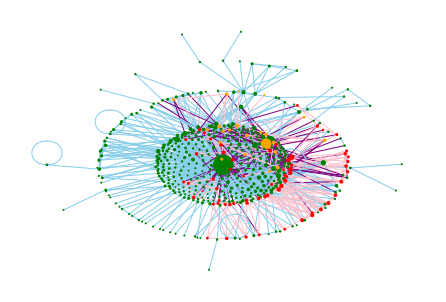

In [223]:
def edge_role_lookup(A,  B, role_lookup):
    Arole = role_lookup[A]
    Brole = role_lookup[B]
    if Arole == Brole:
        if Arole == "Ally":
            return "skyblue"
        else:
            return "pink"
    else:
        return "purple"
    
undirected_largest_cc = largest_subGraph.to_undirected()
edge_list = list(undirected_largest_cc.edges)
role_lookup = nx.get_node_attributes(undirected_largest_cc, "role")

    
edge_colors = [edge_role_lookup(nodeA, nodeB, role_lookup) for (nodeA, nodeB) in edge_list]
color_map = {
    "Ally": "green",
    "Enemy": "red",
    "Boss": "orange"
}
role_list = [node[1]["role"] for node in list(undirected_largest_cc.nodes.data())]
color_values = [color_map[role] for role in role_list]

#size_list = [node[1]["word_count"] for node in list(undirected_largest_cc.nodes.data())]
#size_list = [(x/max(size_list))*300 for x in size_list]
size_list = [node[1] for node in list(undirected_largest_cc.degree)]
nx.draw_kamada_kawai(undirected_largest_cc, node_color=color_values,
                     node_size=size_list, edge_color=edge_colors)

*Exercise 3:* From the previous plot it is more difficult to observe any specific structure in the network. We can make even better visualisations with `ForceAtlas2` package:
>1. [Force Atlas 2 algorithm](https://github.com/bhargavchippada/forceatlas2) helps to determine the positions of the nodes (see what the result looks like below).
>2.You can install the  package typing `pip install fa2` in the terminal. The [github page](https://github.com/bhargavchippada/forceatlas2) explains how to use the package to get coordinates for each node.
>   * (**Hint**: if you install force atlas and Python can't find the package it might be because you computer tries to use the system's `pip`, therefore, try installing using the Anaconda pip explicitly ( on mac you would use `~/anaconda2/bin/pip install fa2`).
> * Visualize the network using the [Networkx draw function](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw), and node-coordinates from the force atlas algorithm. As in the previous Exercise:
>   * Node color should depend on the `role` attribute (i.e. use different colors for allies, enemies, and bosses)
>   * Node size should depend on the node *degree*
>   * **Optional**: edge color should depend on the `role` attribute. If an edge connects allies assign `color_a`, if the edge connects enemies/bosses assign `color_b`, in other cases assign `color_c` (i.e. when allies connect to either enemies or bosses).
> * Play with the force atlas algorithm parameters to obtain a visualization you like. It may look similar to the one below (but not necessarily). 
> * Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes? Do you see any interesting group of nodes (can you guess who's involved)?
>   * **Optional**: try to color nodes on the basis of Gender or Race and compare these plots with the previous one. Can you further characterize the structures you've observed? Do you observe new ones?

![Network](https://github.com/SocialComplexityLab/socialgraphs2021/blob/main/files/Network_fa2.png?raw=true)

In [224]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.5,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

In [225]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=1.5,

                        # Tuning
                        scalingRatio=1.0,

                        # Log
                        verbose=True)

In [226]:
positions = forceatlas2.forceatlas2_networkx_layout(undirected_largest_cc, pos=None, iterations=2000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 161.53it/s]

BarnesHut Approximation  took  1.92  seconds
Repulsion forces  took  9.79  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.08  seconds
AdjustSpeedAndApplyForces step  took  0.28  seconds


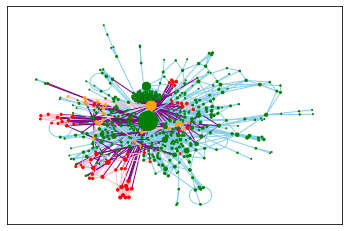

In [227]:
nx.draw_networkx(undirected_largest_cc, pos=positions, with_labels=False, node_color=color_values,
                     node_size=size_list, edge_color=edge_colors)

*Exercise 4*: We continue with a qualitative inspection of the Zelda Wiki pages, that will help us to intepret our results. We investigate the reasons for links between characters to exist on Zelda Wiki.

>1. Consider the top 3 nodes with highest in-degree in the network. Open the corresponding Zelda Wiki page.
>   * Consider the set of neighbours pointing towards the node found above. Look for them in the page. 
>   * What is the relation between the characters you identified and his/her network neighbours? (e.g., do they have the same role, are they opponents). You don't need to come up with a grand theory of BotW here, I just want you to think about how links come about.
>   * Repeat the exercise for the top 3 out-degree node. 
>   * Are there differences between reasons for out- and in-links? Again, there's no right answer here. I just want you to think about some of the reasons why links may occur between characters.
>2. Are there any nodes with high out-degree and with few incoming connections? If yes, open the Zelda Wiki pages of such characters and explain what happens?
>3. Are there any nodes with high in-degree and few outcoming connections? Again, open Zelda Wiki pages of such characters and explain what happens? 
>4. From the plot of the network (in *Exercise 3*), we can see that 2 nodes with highest degrees (other than Link) have many common neighbors. 
    * Can you identify who these characters are? Are they opponents? How many common neighbors do they have? 
    * Can you characterize the common neighbors in terms of their Gender and Race? What about their Zelda Wiki pages (do they have a specific role in the BotW story)?

# Part B:  Advanced tools 

> **Video lecture**: *Network measures*. There's an updated video below, and if you can't get enough, you can watch the original version from 2015 [here](https://www.youtube.com/watch?v=0uAYpOqVHCU).

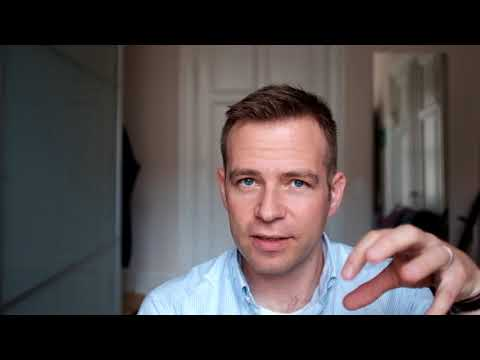

In [228]:
from IPython.display import YouTubeVideo
YouTubeVideo("IOWXZFOyk9Y", width=800, height=450)

*Exercise 1:* Last time we visually analyzed (plotted) the degree distributions of our network. Now, let's analyze it using some of the tools from previous lectures. For this exercise we are going to look at the *directed* graph (rememeber, we asked you to keep one?).

>1. What are the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree? How do you intepret the results?
>    * On top of that, calculate same statistics separately for the network that is spanned only by allies and only by opponents (i.e. enemies and bosses together). How do you interpret the results? 
>    * Repeat the last step, but for the network that is spanned only by females and only by males. How do you interpret the results? 
>2. Let's also look at the *[exponent of the degree distribution](http://networksciencebook.com/chapter/4#degree-exponent)*
>    * To calculate it, you can install `powerlaw` package (I could not install in conda, so I used `pip install powerlaw`)
>    * Use `powerlaw.Fit(degree).alpha` for fitting
>    * Find the degree exponent for in-, out- and total- degree distribution. What does it say about our network?
>    * When analyzing the plots of in- and out- degree distribution last week, did you come up to the same conclusions?
>    * Some long time ago, couple of scientist have analyzed the network that is spanned by the whole Wikipedia (paper is called [Wikipedias: Collaborative web-based encyclopedias as complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.74.016115); to access this paper, use findit.dtu.dk or read the preprint on [arXiv](https://arxiv.org/abs/physics/0602149)). Do your findings correspond to the results described in Chapter **III.A**? If not, why? 
>3. Plot a scatter plot of the the in- versus out- degree for all characters. Comment on the relation between the two.
>4. Plot a heatmap [(Hint here)](https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set) of the the in- versus out- degree for all characters. What is the advantage of using a heatmap over the scatter plot?
>5. Why do you think I want you guys to use a directed graph? Could have we used an undirected graph instead?
>6. We have one more metric that we did not use. The node-attribute `content lenght`. There are two things we can investigate here.
>   * Firstly, we can verify that more text means more links. If that's true the length should correlate with out-degree.
>   * Secondly, and more interestingly, it could be that longer texts means more famous characters. And that means more in-links. 
>   * How should you test this? Well, here you are allowed to be **creative**. You may choose the method of your liking to study this question (e.g. look at it visually, test the correlation using spearman or pearson, fit a curve to the data, you decide). Once you've tested, let me know. Are both questions true? If yes, which phenomenon is stronger? Explain your results in your own words.

### 1

In [229]:
from statistics import mean, mode, median
full_in = [deg for (node, deg) in largest_subGraph.in_degree]
full_out = [deg for (node, deg) in largest_subGraph.out_degree]
full_in_stats = [mean(full_in), median(full_in), mode(full_in), min(full_in), max(full_in)]
full_out_stats = [mean(full_out), median(full_out), mode(full_out), min(full_out), max(full_out)]

In [230]:
ally_nodes = [node for (node, data) in largest_subGraph.nodes.data("role") if data == "Ally"]
ally_graph = largest_subGraph.subgraph(ally_nodes)
ally_in = [deg for (node, deg) in ally_graph.in_degree]
ally_out = [deg for (node, deg) in ally_graph.out_degree]
ally_in_stats = [mean(ally_in), median(ally_in), mode(ally_in), min(ally_in), max(ally_in)]
ally_out_stats = [mean(ally_out), median(ally_out), mode(ally_out), min(ally_out), max(ally_out)]

opponent_nodes = [node for (node, data) in largest_subGraph.nodes.data("role") if data == "Enemy" or data == "Boss"]
opponent_graph = largest_subGraph.subgraph(ally_nodes)
opponent_in = [deg for (node, deg) in opponent_graph.in_degree]
opponent_out = [deg for (node, deg) in opponent_graph.out_degree]
opponent_in_stats = [mean(opponent_in), median(opponent_in), mode(opponent_in), min(opponent_in), max(opponent_in)]
opponent_out_stats = [mean(opponent_out), median(opponent_out), mode(opponent_out), min(opponent_out), max(opponent_out)]

In [231]:
female_nodes = [node for (node, data) in largest_subGraph.nodes.data("gender") if data == "Female"]
female_graph = largest_subGraph.subgraph(ally_nodes)
female_in = [deg for (node, deg) in female_graph.in_degree]
female_out = [deg for (node, deg) in female_graph.out_degree]
female_in_stats = [mean(female_in), median(female_in), mode(female_in), min(female_in), max(female_in)]
female_out_stats = [mean(female_out), median(female_out), mode(female_out), min(female_out), max(female_out)]

male_nodes = [node for (node, data) in largest_subGraph.nodes.data("gender") if data == "Male"]
male_graph = largest_subGraph.subgraph(ally_nodes)
male_in = [deg for (node, deg) in male_graph.in_degree]
male_out = [deg for (node, deg) in male_graph.out_degree]
male_in_stats = [mean(male_in), median(male_in), mode(male_in), min(male_in), max(male_in)]
male_out_stats = [mean(male_out), median(male_out), mode(male_out), min(male_out), max(male_out)]

### 2

In [232]:
import powerlaw

In [233]:
powerlaw.Fit(full_in)

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


In [234]:
powerlaw.Fit(full_out)

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


In [235]:
full_total = [deg for (node, deg) in largest_subGraph.degree]
powerlaw.Fit(full_total)

Calculating best minimal value for power law fit


### 3

c:\users\eg\miniconda3\envs\socialgraphs2021\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


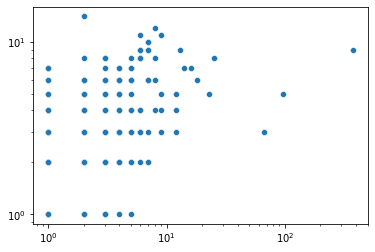

In [236]:
import matplotlib.pyplot as plt
import seaborn as sb
sb.scatterplot(full_in, full_out)
plt.xscale("log")
plt.yscale("log")

### 4

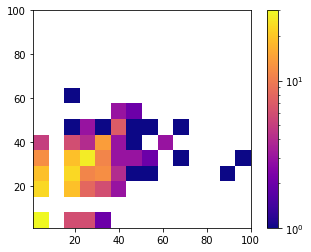

In [237]:
from matplotlib.colors import LogNorm
heatmap, xedges, yedges = np.histogram2d(full_in, full_out, bins=np.logspace(0, 2, 15))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, norm=LogNorm(), cmap="plasma", origin="lower")
plt.colorbar()

### 5

In [238]:
full_word_count = [data for (node, data) in largest_subGraph.nodes.data("word_count")]

Text(0.5, 1.0, 'Correlation of out degree and word count')

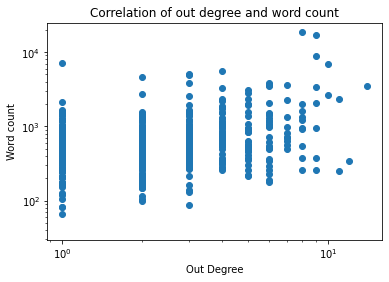

In [239]:
plt.scatter(full_out, full_word_count)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Out Degree")
plt.ylabel("Word count")
plt.title("Correlation of out degree and word count")

Text(0.5, 1.0, 'Correlation of in degree and word count')

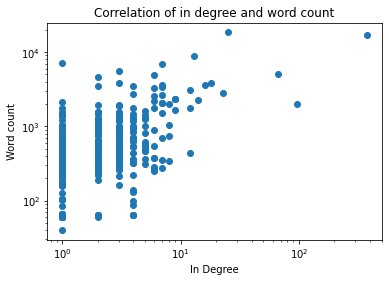

In [240]:
plt.scatter(full_in, full_word_count)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("In Degree")
plt.ylabel("Word count")
plt.title("Correlation of in degree and word count")

## *Exercise 2:* Centralities, assortativity and more.

Earlier, we found the most connected nodes (using degree centrality). Now let's dig in and try to understand more about the network using more advanced features. 

**Note**: Not all of the measures we'll be considering below are defined for directed graphs. Only use the undirected graph when explicitly stated in the exercise.
>1. Find the 5 most central characters according to [degree centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html). 
>2. Find the 5 most central characters according to [betweenness centrality](https://networkx.org/documentation/stable/auto_examples/algorithms/plot_betweenness_centrality.html?highlight=betweenness%20centrality). 
>   * Repeat Exercise A2 or A3 (depending on which visualization method you liked the most). However, this time use betweenness centrality to define the size of the node.
>   * What role do you imagine characters with high betweenness centrality play in the Zelda Wiki? 
>3. Find the 5 most central characters according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see [NetworkX documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html#networkx.algorithms.centrality.eigenvector_centrality) for details). 
>   * Repeat Exercise A2 or A3 (depending on which visualization method you liked the most). However, this time use eigenvector centrality to define the size of the node.
>   * What role do you imagine characters with high wikipedia graph eigenvector centrality play? 
>4. Is the undirected version of the graph assortative with respect to degree? (e.g. do high-degree characters tend to link to other high-degree characters, and low-degree characters to other low-degree characters?). Provide an interpretation of your answer.
>5. Is the undirected version of the graph assortative with respect do the `content length` nodal properties? (e.g. do characters with long Zelda Wiki pages tend to link to other characters with long Wiki pages, and *vice versa*?. Hint: Use [this function](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html#networkx.algorithms.assortativity.attribute_assortativity_coefficient). Provide an interpretation of your answer.
>6. Is the undirected version of the graph assortative with respect to Role, Race, and Gender? (e.g. allies tend to link to allies, bosses to bosses, and enemies to enemies). Provide an interpretation of your answer.
>7. What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes $N$  and probablity of connection $p$?
>   * Take a look at the *distribution* of shortest paths for the two networks (create a histogram for each network) to better compare and contrast. Explain what you see in your own words.

### B.2.1

In [241]:
import heapq

In [242]:
degree_centrality = nx.algorithms.centrality.degree_centrality(largest_subGraph)
heapq.nlargest(5, degree_centrality, key=degree_centrality.get)

['Link', 'Calamity_Ganon', 'Hylia', 'Princess_Zelda', 'Riju']

### B.2.2

In [243]:
betweenness_centrality = nx.algorithms.centrality.betweenness_centrality(largest_subGraph)
heapq.nlargest(5, degree_centrality, key=betweenness_centrality.get)

['Link', 'Calamity_Ganon', 'Impa', 'Urbosa', 'Bokoblin']

In [244]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=1.5,

                        # Tuning
                        scalingRatio=1.0,

                        # Log
                        verbose=True)

In [245]:
positions = forceatlas2.forceatlas2_networkx_layout(largest_subGraph, pos=None, iterations=2000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 185.93it/s]

BarnesHut Approximation  took  1.89  seconds
Repulsion forces  took  8.18  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.31  seconds


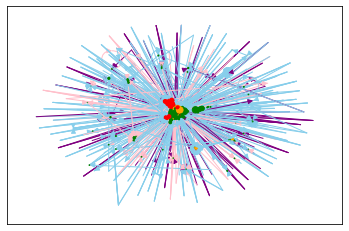

In [246]:
betweenness_centrality_list = [data*1000 for (node, data) in betweenness_centrality.items()]
nx.draw_networkx(largest_subGraph, pos=positions, with_labels=False, node_color=color_values,
                     node_size=betweenness_centrality_list, edge_color=edge_colors)

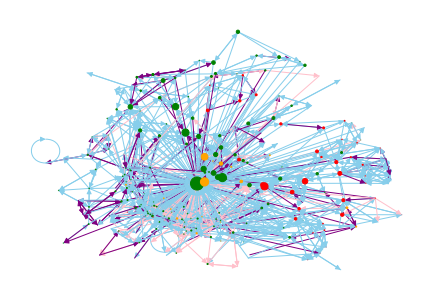

In [247]:
nx.draw_kamada_kawai(largest_subGraph, node_color=color_values,
                     node_size=betweenness_centrality_list, edge_color=edge_colors)

### B.2.3

In [248]:
eigenvector_centrality_in = nx.algorithms.centrality.eigenvector_centrality(largest_subGraph)
eigenvector_centrality_out = nx.algorithms.centrality.eigenvector_centrality(largest_subGraph.reverse())

#### In edges

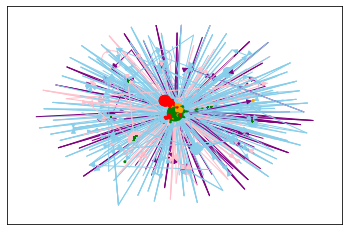

In [249]:
eigenvector_centrality_in_list = [data*500 for (node, data) in eigenvector_centrality_in.items()]
nx.draw_networkx(largest_subGraph, pos=positions, with_labels=False, node_color=color_values,
                     node_size=eigenvector_centrality_in_list, edge_color=edge_colors)

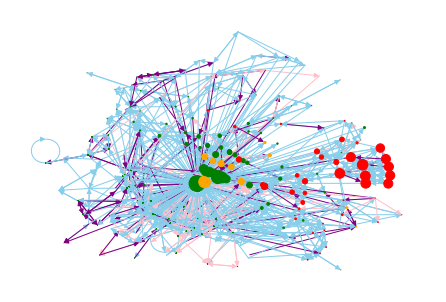

In [250]:
nx.draw_kamada_kawai(largest_subGraph, node_color=color_values,
                     node_size=eigenvector_centrality_in_list, edge_color=edge_colors)

#### Out edges

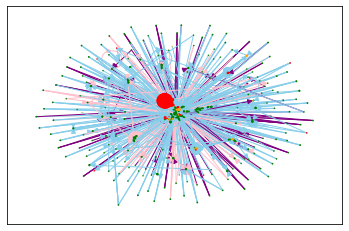

In [251]:
eigenvector_centrality_out_list = [data*500 for (node, data) in eigenvector_centrality_out.items()]
nx.draw_networkx(largest_subGraph, pos=positions, with_labels=False, node_color=color_values,
                     node_size=eigenvector_centrality_out_list, edge_color=edge_colors)

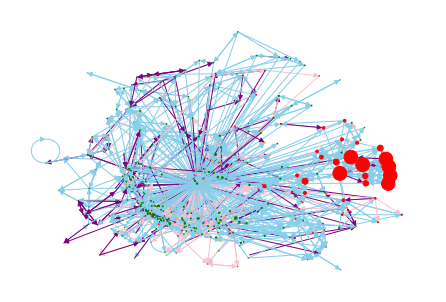

In [252]:
nx.draw_kamada_kawai(largest_subGraph, node_color=color_values,
                     node_size=eigenvector_centrality_out_list, edge_color=edge_colors)

### B.2.4

### B.2.5

In [253]:
nx.algorithms.assortativity.attribute_assortativity_coefficient(undirected_largest_cc, "word_count")

-0.026429069464655952

### B.2.6

In [254]:
print("role", nx.algorithms.assortativity.attribute_assortativity_coefficient(undirected_largest_cc, "role"))
print("gender", nx.algorithms.assortativity.attribute_assortativity_coefficient(undirected_largest_cc, "gender"))
print("race", nx.algorithms.assortativity.attribute_assortativity_coefficient(undirected_largest_cc, "race"))

role 0.5410101474578665
gender 0.3341155772945448
race 0.40243825529891714


### B.2.7

In [255]:
nx.algorithms.shortest_paths.generic.average_shortest_path_length(largest_subGraph)

1.3168059005042523

In [256]:
N = len(largest_subGraph.nodes)


*Exercise 3*: Is the role of a character important for the network structure? Let us explore if and how it shapes the network (use the undirected network). 
>1. Compute the average node centrality for allies and enemies respectively (consider enemies and bosses together). You are free to choose your favourite centrality measure or compare different ones. Which role has the more central characters?
>2. Create a randomized version of the full graph, where the association between nodes and roles is shuffled. Compute the average centrality of allies and enemies (bosses included) for this randomized graph. 
>   * **Hint**: To create this shuffling, simply give everyone a random role assignment (but with the same number of allies, enemies, and bosses as in the real data). The way I usually create random lables is by using either [`random.shuffle`](https://docs.python.org/3/library/random.html#random.shuffle) or [`numpy.random.permutation`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html).
>3. Repeat the shuffling process above 1000 times (at least) and plot two histograms, each histogram with the 1000 corresponding average values of centrality obtained for allies and enemies in the shuffeled netowrks.
>4. Compare the value you have obtained in the real graph, with the randomized cases. Are characters of one role more central in the network (on average)?
>5. Think about your results, what could be possible explanations for what you observe?

### B.3.1

In [258]:
ally_nodes = [node for (node, data) in undirected_largest_cc.nodes.data("role") if data == "Ally"]
ally_graph_undir = undirected_largest_cc.subgraph(ally_nodes)
opponent_nodes = [node for (node, data) in undirected_largest_cc.nodes.data("role") if data == "Enemy" or data == "Boss"]
opponent_graph_undir = undirected_largest_cc.subgraph(opponent_nodes)

In [259]:
ally_centrality = nx.algorithms.centrality.degree_centrality(ally_graph_undir)
opponent_centrality = nx.algorithms.centrality.degree_centrality(opponent_graph_undir)

In [338]:
real_mean_ally_cent = mean([cent for (node, cent) in ally_centrality.items()])
real_mean_opponent_cent = mean([cent for (node, cent) in opponent_centrality.items()])
print("ally mean centrality", real_mean_ally_cent)
print("opponent mean centrality", real_mean_opponent_cent)

ally mean centrality 0.009377866508390438
opponent mean centrality 0.05518207282913165


### B.3.2

In [274]:
import random

In [275]:
ally_count = len(ally_nodes)
opponent_count = len(opponent_nodes)

In [308]:
nodes = list(undirected_largest_cc.nodes)
random.shuffle(nodes)
rand_allies = nodes[:ally_count]
rand_opponents = nodes[ally_count:]

rand_ally_graph = undirected_largest_cc.subgraph(rand_allies)
rand_opponent_graph = undirected_largest_cc.subgraph(rand_opponents)

rand_ally_centrality = nx.algorithms.centrality.degree_centrality(rand_ally_graph)
rand_opponent_centrality = nx.algorithms.centrality.degree_centrality(rand_opponent_graph)

### B.3.3

In [319]:
rand_ally_cent_list = []
rand_opponent_cent_list = []
for i in range(1000):
    random.shuffle(nodes)
    rand_allies = nodes[:ally_count]
    rand_opponents = nodes[ally_count:]

    rand_ally_graph = undirected_largest_cc.subgraph(rand_allies)
    rand_opponent_graph = undirected_largest_cc.subgraph(rand_opponents)

    rand_ally_centrality = nx.algorithms.centrality.degree_centrality(rand_ally_graph)
    rand_opponent_centrality = nx.algorithms.centrality.degree_centrality(rand_opponent_graph)
    
    ally_mean_cent = mean([cent for (node, cent) in rand_ally_centrality.items()])
    opponent_mean_cent = mean([cent for (node, cent) in rand_opponent_centrality.items()])
    
    rand_ally_cent_list.append(ally_mean_cent)
    rand_opponent_cent_list.append(opponent_mean_cent)

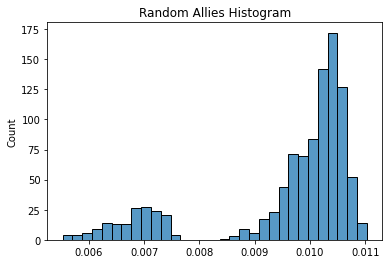

In [330]:
sb.histplot(rand_ally_cent_list, bins="auto") 
plt.title("Random Allies Histogram") 
plt.show()

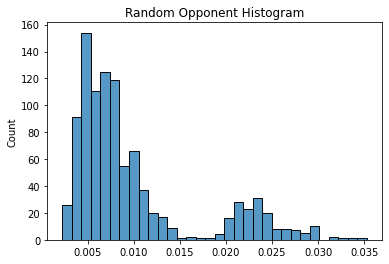

In [331]:
sb.histplot(rand_opponent_cent_list, bins="auto") 
plt.title("Random Opponent Histogram") 
plt.show()

### B.3.4

ally mean centrality 0.009377866508390438

opponent mean centrality 0.05518207282913165

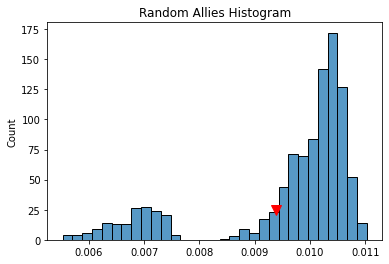

In [350]:
sb.histplot(rand_ally_cent_list, bins="auto") 
plt.title("Random Allies Histogram") 
plt.plot(real_mean_ally_cent, 25, "rv", markersize=10)
plt.show()

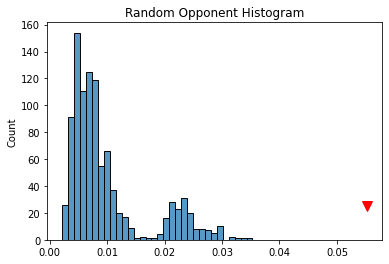

In [351]:
sb.histplot(rand_opponent_cent_list, bins="auto") 
plt.title("Random Opponent Histogram")
plt.plot(real_mean_opponent_cent, 25, "rv", markersize=10)
plt.show()

As can be seen from the plots above, the real mean centralization for allies is slightly below the aerage for a network with random attributes, whereas for the opponents the real mean centralization is so far from the values gotten from the networks with random attributes that NO network has a centralization even remotely close to the real network.

### B.3.5

The explanation is that the opponents are primarily linking to each other in the real network. When randomized there are so few of them that they get spread out a tremedous amount.